# Introductory Analysis of the ATR Dataset

In order to develop a plan for a more thorough analysis, we do some initial exploration of the data. The goals here are to identify general traffic trends pertaining to:
- day of week differences
- long term (multi-year) trends
- data completeness and consistency
- location specific trends / outliers / abnormalities

Visualizing summary statistics of the different locations will provide some ideas for the next directions in the project.

## Import Dependencies and Load Data

This section loads the libraries and calls a utility function implemented to clean up the data into a 'long' format which is more convienent for analysis. In this format, each row of the dataset corresponds to a single one hour measurement. For now, we omit the sections with 15 minute interval data for consistency.

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.colors as pc
import matplotlib.pyplot as plt

# Local python modules are not imported into the virtual environment right now...
# This is a slightly kludgey way to import modules without formally packaging them
import sys
sys.path.append('../src/') 
from utils import load_metadata_pandas, load_processed_pandas

In [2]:
df_traffic = load_processed_pandas()
df_meta = load_metadata_pandas()

# Filters out ATR locations not referenced in the metadata source
merged = pd.merge(df_traffic, df_meta, on='LocationID', how='inner')
valid_ids = merged['LocationID'].unique()
df_meta = df_meta[df_meta['LocationID'].isin(valid_ids)].copy()

### Desired ATR Data

- No lane information
- Only direction specific
- Only valid locations

In [3]:
valid_dirs = ['NB', 'SB', 'EB', 'WB']
mask = (
    (df_traffic['LocationID'].isin(valid_ids)) &
    (df_traffic['Direction'].isin(valid_dirs)) &
    (df_traffic['Lane'].isna())
)
df_traffic = df_traffic[mask].copy()

### 'Shape' of the Loaded and Processed Data

12 unique locations with 2 directions each and 3.25 million hours of data over each location-direction combination.

In [4]:
df_meta

,LocationID,ATR_NAME,LOCATION,HWYNAME,HWYNUMB,COUNTYNAME,LAT,LONGTD
45,26016,Iowa Street,"PACIFIC HIGHWAY NO. 1, 0.94 mile north Terwil...",PACIFIC,1,Multnomah,45.480429,-122.678811
47,34007,North Plains,"SUNSET HIGHWAY NO. 47, NW of North Plains (Gle...",SUNSET,47,Washington,45.59688,-123.014033
54,26024,Glenn Jackson Bridge,"EAST PORTLAND FREEWAY NO. 64, South of Oregon-...",EAST PORTLAND FREEWAY,64,Multnomah,45.582324,-122.543518
86,26002,Vista Ridge Tunne,"SUNSET HIGHWAY NO. 47, West of Stadium Freeway...",SUNSET,47,Multnomah,45.515239,-122.693111
90,26022,Lents,"EAST PORTLAND FREEWAY NO. 64, South of Mt. Hoo...",EAST PORTLAND FREEWAY,64,Multnomah,45.484623,-122.565874
97,3011,Wilsonville,"PACIFIC HIGHWAY NO. 1, South of WilsonvilleHub...",PACIFIC,1,Clackamas,45.266115,-122.780822
108,26001,Troutdale,"COLUMBIA RIVER HIGHWAY NO. 2, West of EB I84 E...",COLUMBIA RIVER,2,Multnomah,45.544584,-122.384229
138,26014,Hoyt,"COLUMBIA RIVER HIGHWAY NO. 2, West of NE 53rd ...",COLUMBIA RIVER,2,Multnomah,45.527421,-122.609379
154,3016,Stafford,"EAST PORTLAND FREEWAY NO. 64, East of PACIFIC ...",EAST PORTLAND FREEWAY,64,Washington,45.368424,-122.753227
156,26004,Interstate Bridge,"PACIFIC HIGHWAY NO. 1, South of OregonWashingt...",JANTZEN BEACH CONN. NO. 2,1,Multnomah,45.612681,-122.678331


In [5]:
df_traffic

,OrigLocationID,LocationID,Lane,DirectionRaw,ParsedDirection,Direction,DateTime,Volume,Year,Hour,Weekend
7,26024_SB,26024,<NA>,SB,SB,SB,2018-07-24 00:00:00-07:00,650,2018,0,False
8,26024_NB,26024,<NA>,NB,NB,NB,2018-05-15 00:00:00-07:00,971,2018,0,False
11,26024_SB,26024,<NA>,SB,SB,SB,2018-01-19 00:00:00-08:00,558,2018,0,True
25,26024_SB,26024,<NA>,SB,SB,SB,2018-03-23 00:00:00-07:00,595,2018,0,True
29,26024_SB,26024,<NA>,SB,SB,SB,2018-09-10 00:00:00-07:00,573,2018,0,False
...,...,...,...,...,...,...,...,...,...,...,...
14648826,26001_EB,26001,<NA>,EB,EB,EB,2000-11-26 23:00:00-08:00,140,2000,23,True
14648827,26014_WB,26014,<NA>,WB,WB,WB,2000-05-03 23:00:00-07:00,1370,2000,23,False
14648828,26014_EB,26014,<NA>,EB,EB,EB,2000-07-02 23:00:00-07:00,1322,2000,23,True
14648829,26014_WB,26014,<NA>,WB,WB,WB,2000-12-18 23:00:00-08:00,1328,2000,23,False


## Duplicates

In this filtered version of the data with only lane aggregated, hourly, and directional data it appears every location has a small amount of duplication. 742 (371 unique combos, always duplicated in pairs) duplicate entries over all 12 locations, but the only hour ever duplicated is 0th hour of the day... this screams DST bugs

Total duplicated datapoints: 742


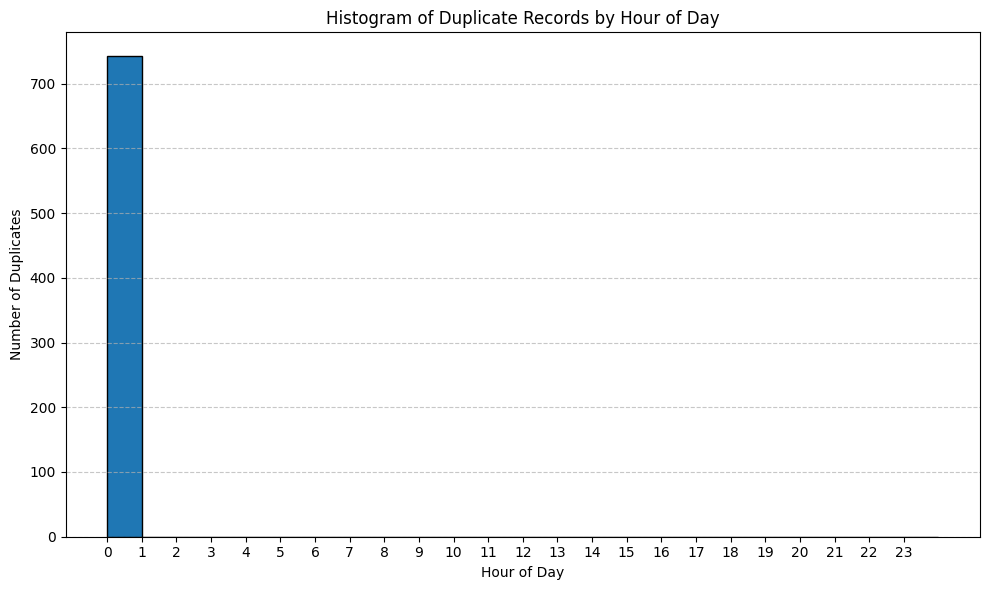

,LocationID,Direction,count
0,3011,NB,30
1,3011,SB,30
2,3016,NB,44
3,3016,SB,44
4,26001,EB,38
5,26001,WB,38
6,26002,EB,28
7,26002,WB,30
8,26004,NB,12
9,26004,SB,12


In [6]:
duplicated = df_traffic.duplicated(subset=['LocationID', 'DateTime', 'Direction'], keep=False)
only_dups = df_traffic[duplicated]
print(f'Total duplicated datapoints: {len(only_dups)}')
duplicate_hours = only_dups['DateTime'].dt.hour

plt.figure(figsize=(10, 6))
plt.hist(duplicate_hours, bins=24, range=(0, 24), edgecolor="black", align="mid")
plt.title("Histogram of Duplicate Records by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Duplicates")
plt.xticks(range(0, 24))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
only_dups.groupby(['LocationID', 'Direction']).size().reset_index(name='count')

By inspecting a specific location / direction for duplications we confirm these are DST issues. Errors in April before 2006 and duplications in March after. Gotta love DST!

In [7]:
print(f"Number of duplicates with same volume value: {len(df_traffic[df_traffic.duplicated(subset=['LocationID', 'DateTime', 'Direction', 'Volume'])])}")
only_dups[(only_dups['LocationID'] == 3016) & (only_dups['Direction'] == 'NB')].sort_values(by='DateTime')[['DateTime', 'Volume', 'Year']]

Number of duplicates with same volume value: 0


,DateTime,Volume,Year
52649,2000-04-03 00:00:00-07:00,225,2000
14092633,2000-04-03 00:00:00-07:00,396,2000
63541,2001-04-02 00:00:00-07:00,280,2001
14095382,2001-04-02 00:00:00-07:00,446,2001
60601,2002-04-08 00:00:00-07:00,272,2002
14094425,2002-04-08 00:00:00-07:00,513,2002
62194,2003-04-07 00:00:00-07:00,249,2003
14105946,2003-04-07 00:00:00-07:00,410,2003
70489,2004-04-05 00:00:00-07:00,270,2004
14103229,2004-04-05 00:00:00-07:00,447,2004


I tried shifting the time of the duplicated values forward and backward an hour to see if it would fill in missing data but the result was the same amount of duplication afterward. Thankfully, throwing away one of the copies of the duplicate data shouldn't be a problem since it is so infrequent and happends in the middle of the night. 

In [8]:
duplicated = df_traffic.duplicated(subset=['LocationID', 'DateTime', 'Direction'])
df_traffic = df_traffic[duplicated == False]

## Coverage Analysis

Let's add the available date ranges for each location into the metadata table.

In [9]:
date_ranges = (
    df_traffic.groupby("LocationID")["DateTime"]
    .agg(min_date="min", max_date="max")
    .reset_index()
)

df_meta = pd.merge(df_meta, date_ranges, on="LocationID", how="left")

In [10]:
ranges = df_meta[['LocationID', 'ATR_NAME', 'min_date', 'max_date']].copy()
ranges['min_date'] = ranges['min_date'].dt.date
ranges['max_date'] = ranges['max_date'].dt.date
ranges.sort_values('min_date')

,LocationID,ATR_NAME,min_date,max_date
0,26016,Iowa Street,2000-01-01,2024-12-24
4,26022,Lents,2000-01-01,2024-12-18
6,26001,Troutdale,2000-01-01,2024-12-24
7,26014,Hoyt,2000-01-01,2024-12-24
8,3016,Stafford,2000-01-01,2024-12-24
1,34007,North Plains,2006-01-01,2024-12-24
5,3011,Wilsonville,2009-10-29,2024-12-22
3,26002,Vista Ridge Tunne,2010-01-30,2024-12-24
10,26028,Fairview,2010-11-03,2024-12-23
2,26024,Glenn Jackson Bridge,2018-01-01,2024-12-23


Most locations seem to have near complete availability but some are missing portions, up to 25% in the worst case. Some of this is noted in the follow-up info provided by Chi.

In [11]:
hourly_coverage = []
for location in df_traffic['LocationID'].unique():
    # Get min and max datetime for this location
    min_date = df_traffic.loc[df_traffic['LocationID'] == location, 'DateTime'].min()
    max_date = df_traffic.loc[df_traffic['LocationID'] == location, 'DateTime'].max()

    expected_range = pd.date_range(start=min_date, end=max_date, freq="h")

    actual_range = df_traffic.loc[df_traffic['LocationID'] == location, 'DateTime']

    missing = len(expected_range.difference(actual_range))
    len_expected = len(expected_range)
    ratio = (len_expected - missing) / len_expected
    hourly_coverage.append({'LocationID': location, 'missing_hours': missing, 'total_hours': len(expected_range), 'ratio': ratio })

hourly_coverage = pd.DataFrame(hourly_coverage).sort_values('ratio')
hourly_coverage

,LocationID,missing_hours,total_hours,ratio
6,26022,55772,218856,0.745166
4,26001,46603,219000,0.787201
5,26016,28414,219000,0.870256
2,3016,26158,219000,0.880557
3,26014,19221,219000,0.912233
7,34007,13746,166392,0.917388
1,26004,4422,61200,0.927745
0,26024,2167,61176,0.964578
8,3011,2440,132817,0.981629
10,26028,2199,123961,0.982261


## Long Term Trends

This function plots the weekday variability in volume aggregated by month over time.

In [12]:
def long_term_monthly_variation(location_id, direction, start="2018-01-01", end="2025-01-01"):
    # Filter data for LocationID 26004 and Direction 'SB'
    filtered_df = df_traffic[
        (df_traffic["LocationID"] == location_id) &
        (df_traffic["Direction"] == direction) &
        (df_traffic["DateTime"] >= start) &
        (df_traffic["DateTime"] <= end) &
        (df_traffic["Weekend"] == False)
    ].copy()
    
    # Extract year and month for grouping
    filtered_df["YearMonth"] = filtered_df["DateTime"].dt.to_period("M")
    
    # Calculate daily total volume
    daily_volume = (
        filtered_df.groupby(["YearMonth", filtered_df["DateTime"].dt.date])["Volume"]
        .sum()
        .reset_index(name="DailyVolume")
    )
    
    # Convert YearMonth to string format for plotting (e.g., "2023-01")
    daily_volume["YearMonth"] = daily_volume["YearMonth"].astype(str)
    
    # Extract years for gridline positions and tick labels
    unique_years = sorted(set(pd.to_datetime(daily_volume["YearMonth"]).dt.year))
    january_ticks = [f"{year}-01" for year in unique_years if f"{year}-01" in daily_volume["YearMonth"].values]
    
    # Create the boxplot
    plt.figure(figsize=(16, 6))
    daily_volume.boxplot(column="DailyVolume", by="YearMonth", grid=False, rot=90, showfliers=False)
    
    # Customize x-axis ticks
    plt.xticks(
        ticks=[i for i, val in enumerate(daily_volume["YearMonth"].unique()) if val in january_ticks],
        labels=[val.split("-")[0] for val in january_ticks],
        rotation=0  # Horizontal labels for readability
    )
    
    # Add vertical gridlines at the start of each year
    for tick in january_ticks:
        if tick in daily_volume["YearMonth"].values:
            plt.axvline(
                x=daily_volume["YearMonth"].unique().tolist().index(tick),
                color="gray",
                linestyle="--",
                linewidth=0.8,
                alpha=0.7,
            )
    meta_info = df_meta[df_meta["LocationID"] == location_id]
    name = meta_info["ATR_NAME"].values[0]

    # Title and labels
    plt.title(f"Variation of Daily Weekday Total Volume ({location_id}: {name}, {direction})")
    plt.suptitle("")  # Remove default subtitle
    plt.xlabel("Year (Monthly Boxes)")
    plt.ylabel("Total Daily Volume")
    plt.tight_layout()
    plt.show()

I5 southbound is interesting, construction closure in 2018 and covid lockdowns in 2020 are clearly visible. It seems that daily total volumn hasn't quite returned to pre-pandemic levels.

/tmp/ipykernel_154013/2393590068.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_df["YearMonth"] = filtered_df["DateTime"].dt.to_period("M")


<Figure size 1600x600 with 0 Axes>

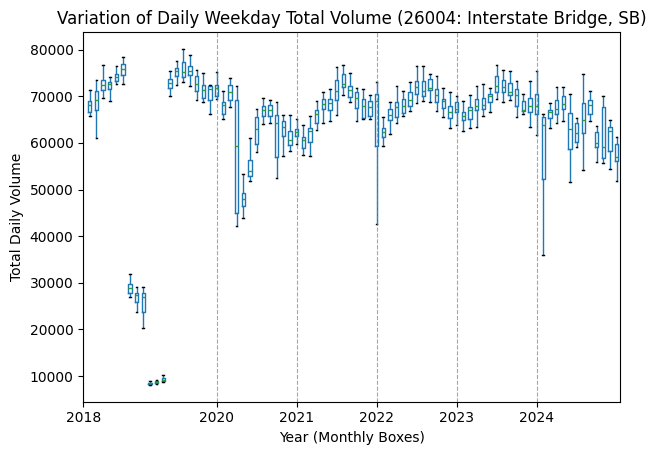

In [13]:
long_term_monthly_variation(26004, 'SB')

Glenn Jackson Bridge southbound complements I5. The low values in 2018-2019 must be missing data from occlusion due to construction because if volume on I5 was as low as presented then I would expect a jump in this bridge crossing during that time which isn't seen here. The drop in 2021 is probably also construction? 

/tmp/ipykernel_154013/2393590068.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_df["YearMonth"] = filtered_df["DateTime"].dt.to_period("M")


<Figure size 1600x600 with 0 Axes>

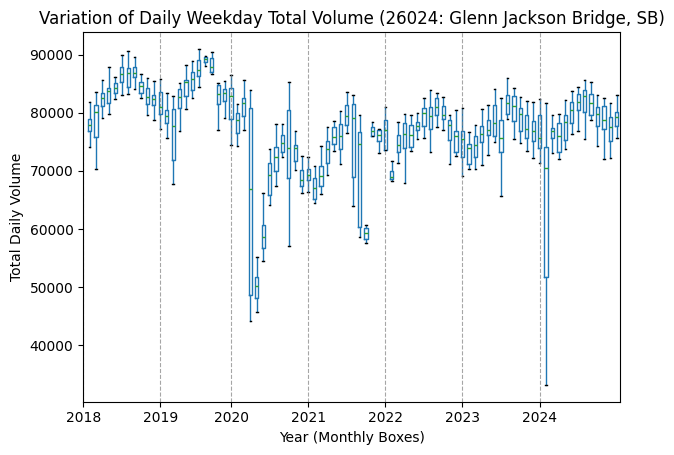

In [14]:
long_term_monthly_variation(26024, 'SB')

We see a similar story of not returning to pre-pandemic volume for Iowa Street northbound, although the massive uptick in the second half of 2021 is interesting. All three of these plots show a giant drop in January of 2024 which I think I remember a big snow storm at that time. 

/tmp/ipykernel_154013/2393590068.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_df["YearMonth"] = filtered_df["DateTime"].dt.to_period("M")


<Figure size 1600x600 with 0 Axes>

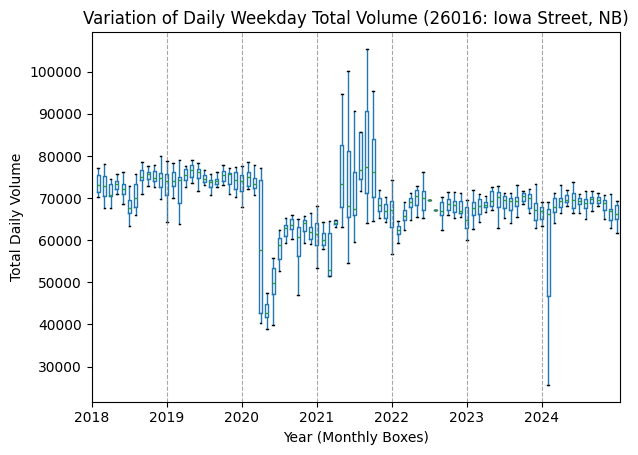

In [15]:
long_term_monthly_variation(26016, 'NB')

Some 0 values for the end of 2024 skew the Vista Ridge eastbound plot so we can filter them out. But again, same consistent story with total volume being lower than the pre-pandemic levels and we have the same drop in early 2024.

/tmp/ipykernel_154013/2393590068.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_df["YearMonth"] = filtered_df["DateTime"].dt.to_period("M")


<Figure size 1600x600 with 0 Axes>

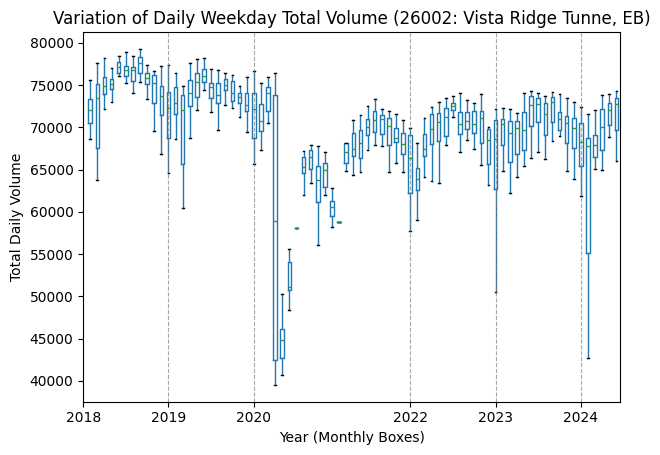

/tmp/ipykernel_154013/2393590068.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_df["YearMonth"] = filtered_df["DateTime"].dt.to_period("M")


<Figure size 1600x600 with 0 Axes>

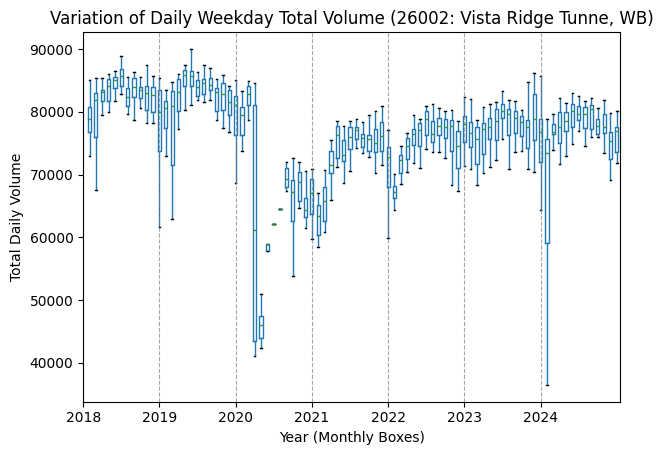

In [16]:
long_term_monthly_variation(26002, 'EB', end="2024-06-01")
long_term_monthly_variation(26002, 'WB')

## Hourly Traffic Dynamics

It seems that total volumes have decreased when looking at typical weekday commutes into the Portland central area. This indicates we should take a closer look at the peak-volume periods and study the hourly structure to see if traffic dynamics have different properties throughout the day when compared to pre-pandemic data.

In [17]:
def plot_hourly_weekdays(location_id, direction, periods=[("2018-01-01", "2019-12-31"), ("2023-01-01", "2024-12-31")]):

    meta_info = df_meta[df_meta['LocationID'] == location_id]
    name = meta_info["ATR_NAME"].values[0]

    df_filtered = df_traffic[
        (df_traffic['LocationID'] == location_id) &
        (df_traffic["Direction"] == direction) &
        (df_traffic["Weekend"] == False)
    ].copy()

    plt.figure(figsize=(16, 6))
    
    for i, (p_start, p_end) in enumerate(periods):
        df_p = df_filtered[
            (df_filtered["DateTime"] >= p_start) &
            (df_filtered["DateTime"] <= p_end)
        ].copy()

        stats_p = (
            df_p.groupby(['Hour'])['Volume']
                  .agg(
                      mean='median',
                      Q1=lambda x: x.quantile(0.25),
                      Q3=lambda x: x.quantile(0.75)
                  )
                  .reset_index()
        )
        stats_p['IQR'] = stats_p['Q3'] - stats_p['Q1']

        color = f'C{i}'
        plt.plot(stats_p['Hour'], stats_p['mean'], color=color, label=f'{p_start} to {p_end}')
        plt.fill_between(stats_p['Hour'], stats_p['Q1'], stats_p['Q3'],
                                alpha=0.2, color=color)

    hours = np.arange(0, 24, 2)
    hour_labels = [f"{h:02d}:00" for h in hours]

    plt.xticks(hours, hour_labels, rotation=45, ha='right')
    plt.xlim(0, 23)
    plt.xlabel("Time of Day")
    plt.ylabel("Volume")

    plt.grid(True, which='both', axis='both', alpha=0.3)
    plt.legend(loc='upper right')
    plt.title(f'{location_id} - {name} {direction}')
    plt.tight_layout()
    plt.show()

Filtering different locations based on outliers discovered in long term trends we can look at the hourly breakdown of weekday traffic. This breakdown seems to generally agree with the long term findings that pre-pandemic volumes were higher.

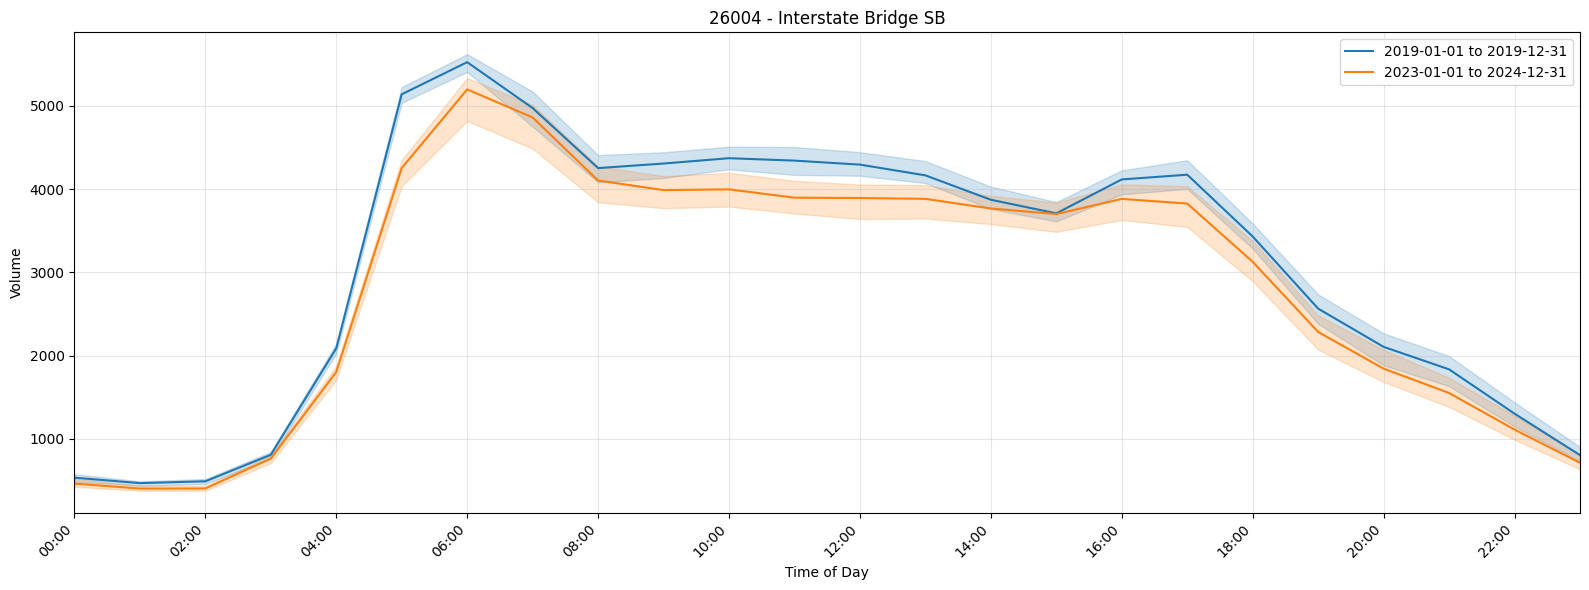

In [18]:
plot_hourly_weekdays(26004, 'SB', periods=[("2019-01-01", "2019-12-31"), ("2023-01-01", "2024-12-31")])

Similar story for Glenn Jackson

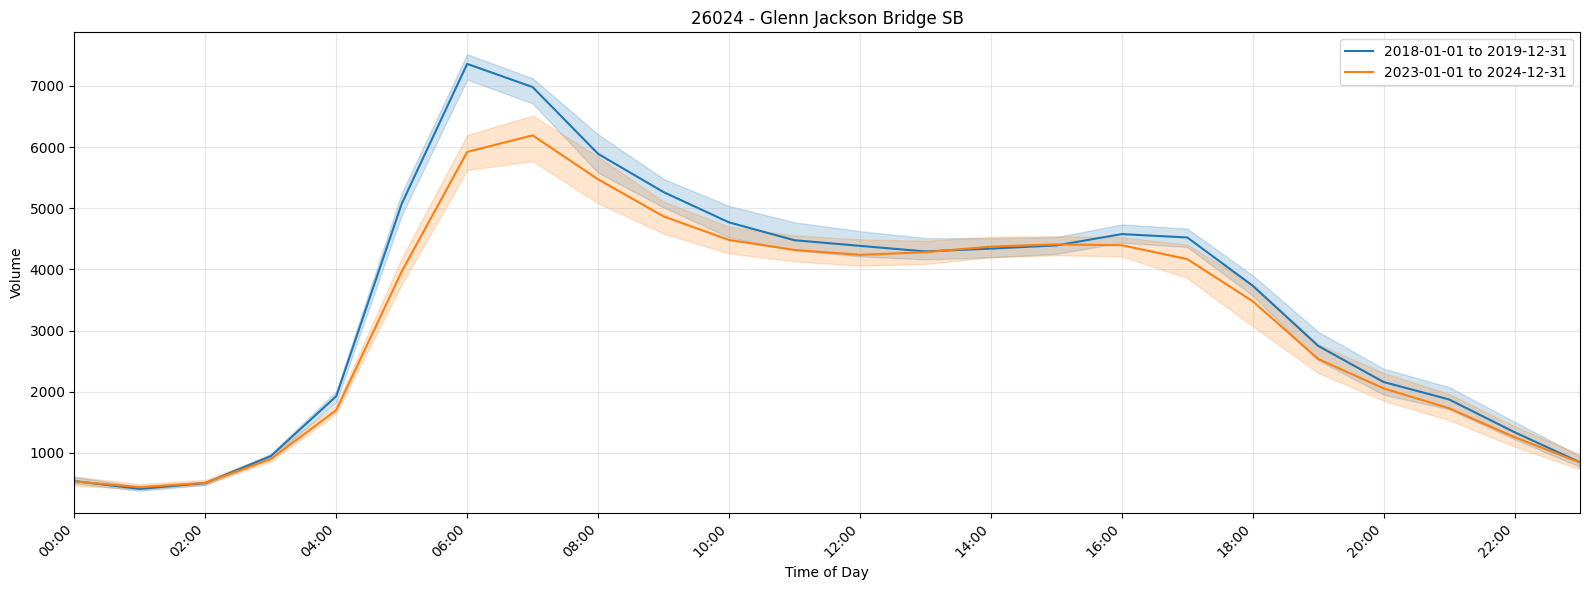

In [19]:
plot_hourly_weekdays(26024, 'SB')

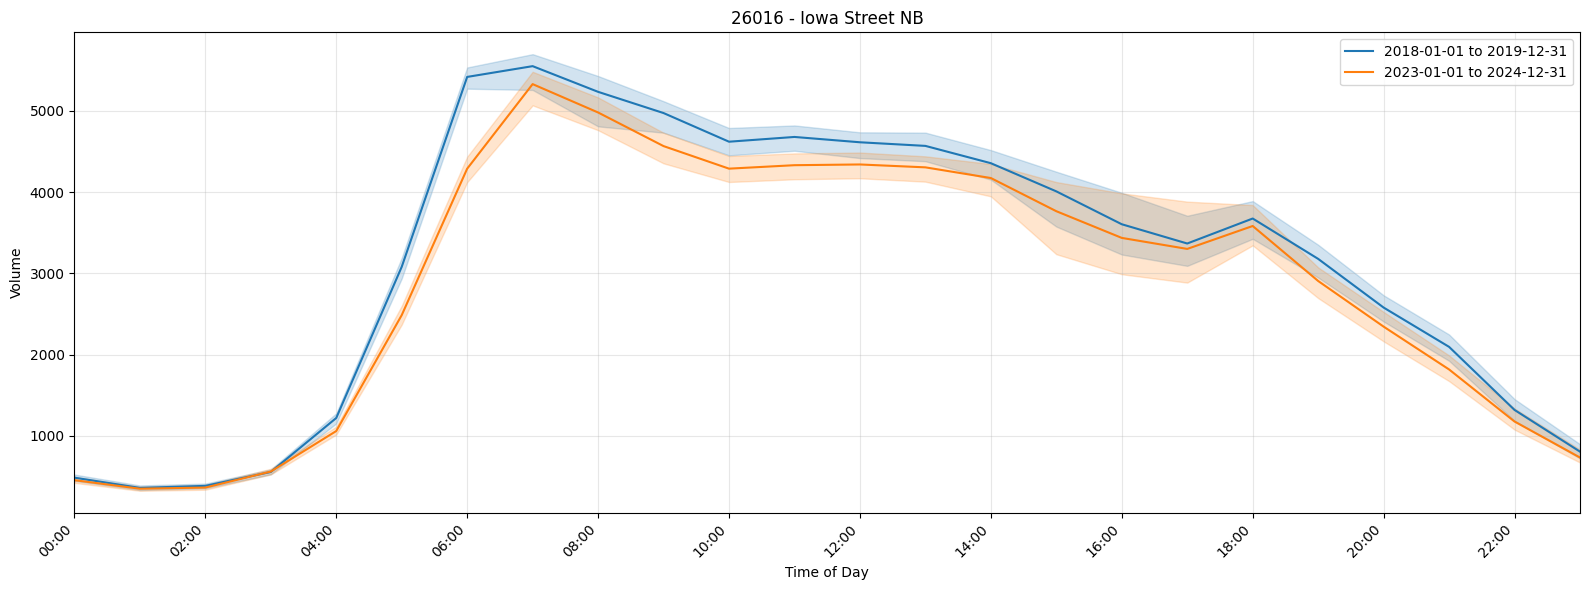

In [20]:
plot_hourly_weekdays(26016, 'NB')

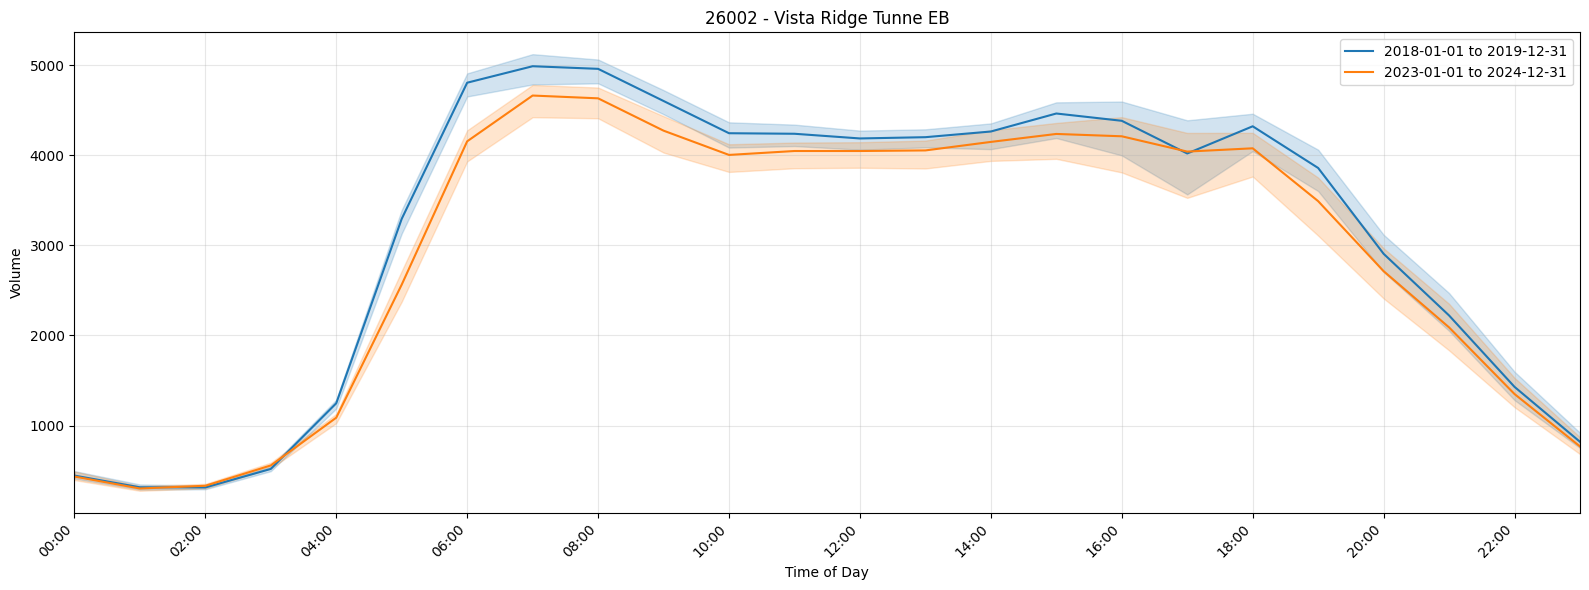

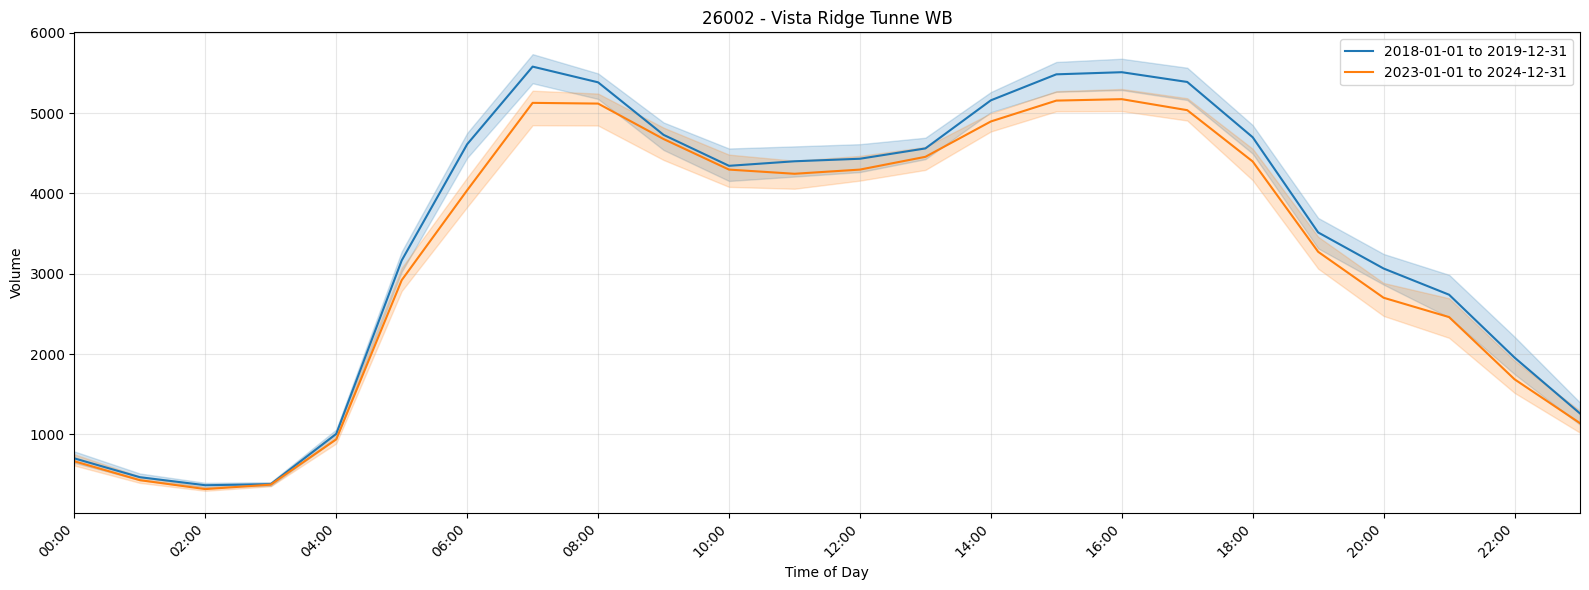

In [21]:
plot_hourly_weekdays(26002, 'EB')
plot_hourly_weekdays(26002, 'WB')

### Further Hourly Exploration

For more granualar options in comparing different plots, periods, and days of the week check out this [Dash App](https://aujxn.dev/traffic) I created for easier data exploration.